# Analysis of CRDC referral and arrest data

In [1]:
import numpy as np
import pandas as pd


In [2]:
enr = pd.read_csv("input/enrollment.csv", low_memory=False)
ref = pd.read_csv("input/referrals.csv", low_memory=False)
arr = pd.read_csv("input/arrests.csv", low_memory=False)
cha = pd.read_csv("input/characteristics.csv", low_memory=False)


In [3]:
HVPLOT_ARGS = {
    "backend": "hvplot",
    "width": 900,
    "height": 600,
}


In [4]:
def add_column_level(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """helper function to add a single named column level to a dataframe"""
    df.columns = pd.MultiIndex.from_tuples([(name, col) for col in df.columns])
    return df


def div_multiindex(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """assigns a new column to dataframe, dividing provided name by the enrollment column"""
    return df.assign(**{name: lambda df: df[name] / df.enrollment * 1000})


def school_crosstab(columns: str) -> pd.DataFrame:
    """generates a crosstab from enrollment, referral and arrest data

    Args:
        columns (str): name to use as columns, passed to pd.crosstab

    Returns:
        pandas.DataFrame
    """
    return (
        # crosstab for enrollment by disability status
        pd.crosstab(
            index=enr.combokey,
            columns=enr[columns],
            values=enr.enrollment,
            aggfunc=sum,
        )
        .pipe(add_column_level, "enrollment")
        # join referrals and arrests
        .join(
            pd.crosstab(
                index=arr.combokey,
                columns=arr[columns],
                values=arr.arrests,
                aggfunc=sum,
            ).pipe(add_column_level, "arrests")
        )
        .join(
            pd.crosstab(
                index=ref.combokey,
                columns=ref[columns],
                values=ref.referrals,
                aggfunc=sum,
            ).pipe(add_column_level, "referrals")
        )
        # drop any null values, which are an indication that one or more fields is missing data
        .dropna(how="any")
    )


def national_rates(df: pd.DataFrame) -> pd.DataFrame:
    """calculates the overall referral rates for a dataframe generated by school_crosstab"""
    df = (
        df.sum()
        .to_frame()
        .transpose()
        .pipe(div_multiindex, "arrests")
        .pipe(div_multiindex, "referrals")
        .drop("enrollment", axis=1)
    )
    df.index = ["United States"]
    return df


def plot_national(df: pd.DataFrame) -> pd.DataFrame:
    """calls pandas.DataFrame.plot on the output of national_rates"""
    return (
        df.stack()
        .droplevel(0)
        .assign(all=lambda df: df.arrests + df.referrals)
        .sort_values("all")
        .drop("all", axis=1)
        .transpose()
        .plot(
            kind="bar",
            title="Referrals and arrests per 1,000 students",
        )
    )


def state_rates(df: pd.DataFrame, col1: str, col2: str) -> pd.DataFrame:
    """
    calculates referral rates by state, adding percent change columns for the provided col1 and col2
    """
    compare = (
        lambda df, col: ((df[(col, col1)] - df[(col, col2)]) / df[(col, col2)])
        .multiply(100)
        .to_frame((col, f"{col1}_vs_{col2}"))
    )

    return (
        pd.concat(
            [
                df.join(
                    cha.set_index("combokey")[["lea_state_name"]].pipe(
                        add_column_level, "characteristics"
                    )
                )
                .groupby(("characteristics", "lea_state_name"))
                .sum()
                .pipe(div_multiindex, "arrests")
                .pipe(div_multiindex, "referrals")
                .drop("enrollment", axis=1),
                national_rates(df),
            ]
        )
        .pipe(lambda df: df.join(compare(df, "arrests")))
        .pipe(lambda df: df.join(compare(df, "referrals")))
    )


## Disability status

In [5]:
def calculate_without_disabilities(df, name):
    df[(name, "without_disabilities")] = df[("enrollment", "overall")] - (
        df[("enrollment", "idea")] + df[("enrollment", "section_504")]
    )
    return df.drop((name, "overall"), axis=1)


disability_status = school_crosstab("variable").pipe(
    calculate_without_disabilities, "enrollment"
)
disability_status


enrollment             arrests                                   \
                   idea section_504    idea section_504 without_disabilities   
combokey                                                                       
061551001969       42.0         4.0     0.0         0.0                  0.0   
061551001970       25.0        19.0     0.0         0.0                  0.0   
061551001971       43.0         8.0     0.0         0.0                  0.0   
061551001972       30.0         3.0     0.0         0.0                  0.0   
061551001973       52.0        15.0     0.0         0.0                  0.0   
...                 ...         ...     ...         ...                  ...   
720003002079      145.0         0.0     0.0         0.0                  0.0   
720003002082      149.0         0.0     0.0         0.0                  0.0   
720003002083       64.0         0.0     0.0         0.0                  0.0   
720003002084      103.0         1.0     0.0         0.0                  0.0   
720003002085      138.0         0.0     0.0         0.0                  0.0   

             referrals                                            enrollment  
                  idea section_504 without_disabilities without_disabilities  
combokey                                                                      
061551001969       0.0         0.0                  0.0                347.0  
061551001970       0.0         0.0                  0.0                432.0  
061551001971       0.0         0.0                  0.0                376.0  
061551001972       0.0         0.0                  0.0                440.0  
061551001973       0.0         0.0                  0.0                365.0  
...                ...         ...                  ...                  ...  
720003002079       0.0         0.0                  0.0                336.0  
720003002082       6.0         0.0                  4.0                348.0  
720003002083       0.0         0.0                  0.0                120.0  
720003002084       0.0         0.0                  0.0                286.0  
720003002085       0.0         0.0                  0.0                554.0  

[83093 rows x 9 columns]

### National

In [6]:
disability_status_national = national_rates(disability_status)
disability_status_national


/tmp/ipykernel_20503/2451445795.py:55: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.sum()


arrests                                  referrals              \
                  idea section_504 without_disabilities      idea section_504   
United States  2.20429    1.519182             0.931161  8.948268    5.836518   

                                    
              without_disabilities  
United States             3.701984

<AxesSubplot:title={'center':'Referrals and arrests per 1,000 students'}>

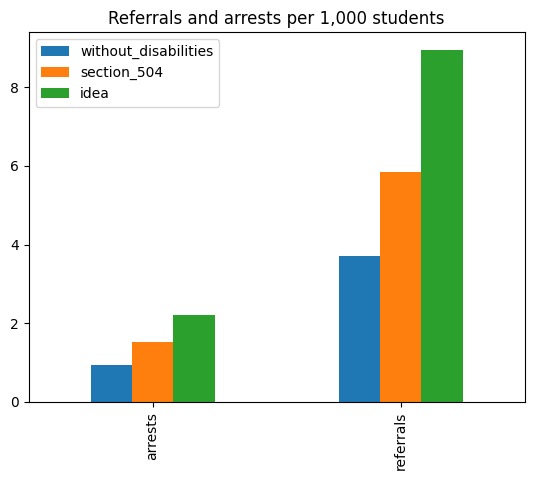

In [7]:
plot_national(disability_status_national)


### By state

In [8]:
disability_status_state = state_rates(disability_status, "idea", "without_disabilities")
disability_status_state.round(2)


/tmp/ipykernel_20503/2451445795.py:95: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.join(
/tmp/ipykernel_20503/2451445795.py:55: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.sum()


arrests                                  referrals  \
                        idea section_504 without_disabilities      idea   
California              0.89        0.43                 0.32      6.48   
Colorado                0.59        0.40                 0.14     11.17   
Delaware                4.02        1.65                 1.16     14.10   
District Of Columbia    1.16        1.15                 0.33      3.72   
Florida                 1.69        1.81                 0.68     15.51   
Georgia                 2.48        1.26                 1.33      5.47   
Hawaii                  7.25        2.45                 0.00      9.16   
Idaho                   0.47        0.42                 0.22     11.78   
Illinois                2.56        0.66                 0.95      8.41   
Indiana                 2.50        0.43                 1.54      4.67   
Iowa                    4.61        1.98                 1.58     10.71   
Kansas                  2.12        1.38                 1.03      7.92   
Kentucky                1.25        0.63                 0.55      8.18   
Louisiana               1.10        0.52                 0.94      4.33   
Maine                   0.57        0.23                 0.18      7.04   
Maryland                5.43        4.26                 2.08     11.20   
Massachusetts           0.56        0.16                 0.20      3.15   
Michigan                0.65        0.20                 0.47      4.09   
Minnesota               1.51        0.48                 0.33     12.72   
Mississippi             2.43        2.55                 1.54      6.24   
Missouri                3.60        1.95                 1.50      9.76   
Montana                 2.50        0.62                 1.48     11.34   
Nebraska                1.56        1.51                 0.66      8.62   
Nevada                  4.46        3.06                 1.70      8.70   
New Hampshire           2.10        1.77                 1.51     18.70   
New Jersey              0.90        0.44                 0.42      4.64   
New Mexico              0.40        0.00                 0.25      4.73   
New York                1.04        0.27                 0.28      2.87   
North Carolina          0.65        0.23                 0.18      7.76   
North Dakota            3.80        0.38                 1.02     10.25   
Ohio                    1.17        0.35                 0.40      4.01   
Oklahoma                2.27        1.67                 1.07      5.67   
Oregon                  0.80        0.89                 0.35      3.58   
Pennsylvania            4.95        1.62                 1.68     21.47   
Puerto Rico             0.00        0.00                 0.00      0.43   
Rhode Island            1.41        0.57                 1.29      3.95   
South Carolina          2.38        2.08                 1.47      6.49   
South Dakota            4.00        0.80                 2.19     15.82   
Tennessee               2.97        1.08                 1.34      5.92   
Texas                   4.77        2.91                 1.81      8.93   
Utah                    0.45        0.00                 0.28      5.10   
Vermont                 0.95        0.00                 0.05      9.22   
Virginia                3.89        1.31                 1.36     31.47   
Washington              1.96        2.08                 0.88      4.66   
West Virginia           0.18        0.00                 0.13      3.03   
Wisconsin               3.91        0.86                 1.19     21.31   
Wyoming                 0.15        0.00                 0.13     11.82   
United States           2.20        1.52                 0.93      8.95   

                                                       \
                     section_504 without_disabilities   
California                  3.14                 3.25   
Colorado                    7.39                 3.84   
Delaware                    4.95          

## Race


In [9]:
race = school_crosstab("race")
race


enrollment                       \
             american indian/alaskan native asian black hispanic   
combokey                                                           
061551001969                              2    31     5      258   
061551001970                              0    21     3      165   
061551001971                              0    19     0      282   
061551001972                              1    73     8      272   
061551001973                              0    59     4      202   
...                                     ...   ...   ...      ...   
720003002079                              0     0     0      626   
720003002082                              0     4     0      641   
720003002083                              0     0     0      248   
720003002084                              0     0     0      493   
720003002085                              1     0     0      829   

                                                                       \
             native hawaiian/pacific islander two or more races white   
combokey                                                                
061551001969                                1                23   119   
061551001970                                0                43   288   
061551001971                                0                32   145   
061551001972                                0                30   122   
061551001973                                0                41   193   
...                                       ...               ...   ...   
720003002079                                0                 0     0   
720003002082                                0                 0     1   
720003002083                                0                 0     0   
720003002084                                0                 0     1   
720003002085                                0                 0     0   

                                    arrests              ...  \
             american indian/alaskan native asian black  ...   
combokey                                                 ...   
061551001969                            0.0   0.0   0.0  ...   
061551001970                            0.0   0.0   0.0  ...   
061551001971                            0.0   0.0   0.0  ...   
061551001972                            0.0   0.0   0.0  ...   
061551001973                            0.0   0.0   0.0  ...   
...                                     ...   ...   ...  ...   
720003002079                            0.0   0.0   0.0  ...   
720003002082                            0.0   0.0   0.0  ...   
720003002083                            0.0   0.0   0.0  ...   
720003002084                            0.0   0.0   0.0  ...   
720003002085                            0.0   0.0   0.0  ...   

                                                                       \
             native hawaiian/pacific islander two or more races white   
combokey                                                                
061551001969                              0.0               0.0   0.0   
061551001970                              0.0               0.0   0.0   
061551001971                              0.0               0.0   0.0   
061551001972                              0.0               0.0   0.0   
061551001973                              0.0               0.0   0.0   
...                                       ...               ...   ...   
720003002079                              0.0               0.0   0.0   
720003002082                              0.0               0.0   0.0   
720003002083                              0.0               0.0   0.0   
720003002084                              0.0               0.0   0.0   
720003002085                              0.0               0.0   0.0   

                                  referrals                       \
             american indian/alaskan native asian black hispanic   
c

### National

In [10]:
race_national = national_rates(race)
race_national


/tmp/ipykernel_20503/2451445795.py:55: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.sum()


arrests                               \
              american indian/alaskan native     asian    black  hispanic   
United States                        1.41474  0.215618  1.93671  0.936488   

                                                                            \
              native hawaiian/pacific islander two or more races     white   
United States                         1.148526          0.916078  0.651697   

                                   referrals                                \
              american indian/alaskan native     asian     black  hispanic   
United States                       5.687696  1.063961  6.878364  3.417306   

                                                                            
              native hawaiian/pacific islander two or more races     white  
United States                         4.383264          4.008341  3.003655

<AxesSubplot:title={'center':'Referrals and arrests per 1,000 students'}>

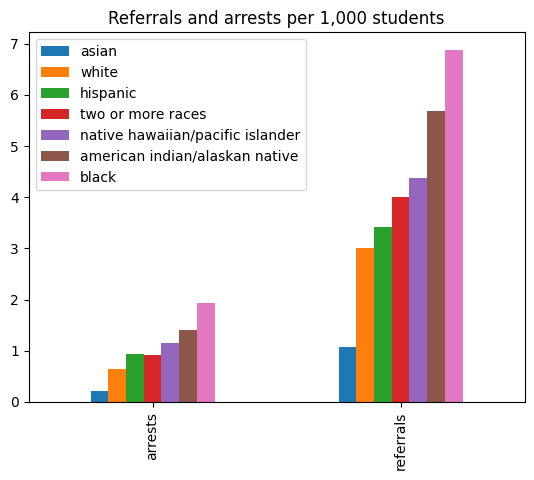

In [11]:
plot_national(race_national)


### By state

In [12]:
race_state = state_rates(race, "black", "white")
race_state.round(2)


/tmp/ipykernel_20503/2451445795.py:95: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.join(
/tmp/ipykernel_20503/2451445795.py:55: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.sum()


arrests                       \
                     american indian/alaskan native asian black hispanic   
California                                     0.63  0.18  0.95     0.35   
Colorado                                       0.17  0.00  0.42     0.21   
Delaware                                       1.47  0.36  2.75     1.01   
District Of Columbia                           0.00  0.00  0.52     0.12   
Florida                                        0.30  0.08  1.48     0.41   
Georgia                                        1.51  0.47  1.96     0.96   
Hawaii                                         3.86  0.20  0.00     0.27   
Idaho                                          0.00  0.00  1.33     0.33   
Illinois                                       0.00  0.19  1.96     0.97   
Indiana                                        0.79  0.63  2.96     0.97   
Iowa                                           3.51  0.15  7.89     2.09   
Kansas                                         2.96  0.54  2.70     0.75   
Kentucky                                       0.00  0.08  2.48     0.45   
Louisiana                                      0.88  0.16  1.19     0.37   
Maine                                          0.63  0.00  0.88     0.00   
Maryland                                       2.54  0.29  3.74     0.93   
Massachusetts                                  0.38  0.01  0.62     0.42   
Michigan                                       0.83  0.07  0.43     0.15   
Minnesota                                      0.93  0.08  1.35     0.54   
Mississippi                                    0.76  0.53  1.88     0.38   
Missouri                                       0.74  0.36  2.24     1.47   
Montana                                        4.13  0.00  2.10     0.17   
Nebraska                                       1.13  0.52  1.50     0.75   
Nevada                                         4.16  0.36  3.20     1.60   
New Hampshire                                  0.00  0.91  4.11     0.60   
New Jersey                                     0.45  0.18  0.77     0.47   
New Mexico                                     0.84  0.00  0.26     0.17   
New York                                       0.00  0.07  0.66     0.17   
North Carolina                                 0.05  0.05  0.45     0.16   
North Dakota                                   4.19  0.44  2.42     1.18   
Ohio                                           0.00  0.07  1.04     0.21   
Oklahoma                                       0.75  0.20  3.14     1.23   
Oregon                                         0.96  0.00  0.19     0.33   
Pennsylvania                                   2.97  0.30  3.34     2.63   
Puerto Rico                                    0.00  0.00  0.00     0.00   
Rhode Island                                   5.89  0.19  2.18     1.56   
South Carolina                                 1.25  0.15  2.13     0.80   
South Dakota                                   6.58  0.76  1.18     2.72   
Tennessee                                      1.43  0.42  2.32     0.88   
Texas                                          1.89  0.35  2.97     2.05   
Utah                                           0.77  0.00  0.53     0.40   
Vermont                                        0.00  0.00  1.61     1.10   
Virginia                                       1.25  0.33  3.61     1.24   
Washington                                     0.54  0.20  0.83     0.56   
West Virginia                                  0.00  0.00  0.51     0.55   
Wisconsin                                      4.02  0.35  4.32     1.20   
Wyoming                                        0.00  0.00  0.00     0.07   
United States                                  1.41  0.22  1.94     0.94   

                                                                               \
                     native hawaiian/pacific islander two or more races white   
California                                       0.34              0.39  0.22   
